# Home Credit Default Risk
このnotebookでは、予測結果を作成するまでの流れと基本的な手法についての紹介を行います。


まずは、今回のタスクについて確認しましょう（詳細はREADME.ipynbをご覧ください）。
- **目的**： 顧客データから債務不履行になる確率を予測する。
- **評価指標**： AUC（Area Under the Curve）

## 目次
0. ライブラリ・データの読み込み
1. データの可視化と分析
2. 前処理と特徴量作成
3. 機械学習モデルの作成
4. 予測結果の作成

## 0. ライブラリ・データの読み込み

基本的なライブラリを読み込みます。
他の必要なライブラリについては、説明をする際に読み込みます。
- numpy：数値計算を効率的に行うライブラリ
- pandas：データ分析に便利なライブラリ
- matplotlib：グラフ描画ライブラリ
- seaborn：グラフ描画ライブラリ

In [2]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
# LGBMClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from hyperopt import hp, fmin, tpe, Trials
import warnings
warnings.filterwarnings('ignore')

In [3]:
# exel表にparameter,scoreを記録する関数
import os
def save_score_to_exel(exel_path , best: dict, score, time):
    columns = list(best.keys())
    columns.append('score')
    columns.append('time')
    old = pd.DataFrame(columns = columns)
    if not os.path.exists(exel_path):
        old.to_excel(exel_path)
    old = pd.read_excel(exel_path, index_col=0)
    data = list(best.values())
    data.append(score)
    data.append(time)
    new = np.array([data])
    score_data = pd.DataFrame(columns = columns, data = new)
    new = pd.concat([old, score_data])
    new.to_excel(exel_path)

In [4]:
# データの読み込み
# INPUT_DIRにtrain.csvなどのデータを置いているディレクトリを指定してください。
INPUT_DIR = "./input/"
import datetime
time = datetime.datetime.now().strftime('%Y%m%d%H%M')
output_path = "C:/Users/gwsgs/workSpace/GCIcomp2/02.（公開）コンペ2/output/"
train = pd.read_csv(INPUT_DIR + "train.csv")
test = pd.read_csv(INPUT_DIR + "test.csv")
sample_sub = pd.read_csv(INPUT_DIR + "sample_submission.csv")
X_train = train.drop('TARGET',axis=1)
y_train = train['TARGET']

In [5]:
# import sweetviz as sv

# # # Sweetvizの分析レポートを作成（学習データとテストデータの比較、目的変数を指定）
# report = sv.compare([X_train, "Train Data"], [y_train, "Test Data"], target_feat='TARGET')

# # # レポートをHTMLファイルとして保存
# report.show_html(open_browser=True)

## 2. 前処理と特徴量作成
ここでは、上記の可視化と分析でわかったことを踏まえて、前処理と特徴量の作成を行います。

In [17]:
params = {
    'random_state': 0,
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'num_leaves': hp.randint('num_leaves',2, 100),
    'max_depth': hp.randint('max_depth',2, 3),
    'n_estimators': hp.randint('n_estimators',800, 1200),
    'learning_rate': hp.uniform('learning_rate', 0.005 ,0.2),
    # 'min_child_samples': hp.randint('min_child_samples',5, 10),
    'reg_lamb': hp.uniform('reg_lamb', 0, 40),
    'bagging_freq': hp.randint('bagging_freq', 1, 10),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.1, 1),
    'feature_fraction': hp.uniform('feature_fraction', 0.1, 1),
    'min_data_in_leaf': hp.randint('min_data_in_leaf', 10, 100),
}

In [7]:
# 欠損値の補完を行う
# FLAF_OWN_CARの欠損値はY=1, N=0, Nan=2で補完 
train["FLAG_OWN_CAR"].fillna(2, inplace=True)
train["FLAG_OWN_CAR"] = train["FLAG_OWN_CAR"].map({"Y": 1, "N": 0, 2: 2})
test["FLAG_OWN_CAR"].fillna(2, inplace=True)
test["FLAG_OWN_CAR"] = test["FLAG_OWN_CAR"].map({"Y": 1, "N": 0, 2: 2})
# FLAG_OWN_REALTYの欠損値はY=1, N=0, Nan=2で補完
train["FLAG_OWN_REALTY"].fillna(2, inplace=True)
train["FLAG_OWN_REALTY"] = train["FLAG_OWN_REALTY"].map({"Y": 1, "N": 0, 2: 2})
test["FLAG_OWN_REALTY"].fillna(2, inplace=True)
test["FLAG_OWN_REALTY"] = test["FLAG_OWN_REALTY"].map({"Y": 1, "N": 0, 2: 2})
# AMT_ANNUITYの欠損値を中央値で補完
train["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].median(), inplace=True)
test["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].median(), inplace=True)
# AMT_GOODS_PRICEの欠損値を中央値で補完
train["AMT_GOODS_PRICE"].fillna(train["AMT_GOODS_PRICE"].median(), inplace=True)
test["AMT_GOODS_PRICE"].fillna(train["AMT_GOODS_PRICE"].median(), inplace=True)
# NAME_TYPE_SUITEの欠損値をラベルエンコーディングで補完
train["NAME_TYPE_SUITE"].fillna("Unknown", inplace=True)
train["NAME_TYPE_SUITE"] = train["NAME_TYPE_SUITE"].map(train["NAME_TYPE_SUITE"].value_counts().rank(ascending=False, method='first'))
test["NAME_TYPE_SUITE"].fillna("Unknown", inplace=True)
test["NAME_TYPE_SUITE"] = test["NAME_TYPE_SUITE"].map(test["NAME_TYPE_SUITE"].value_counts().rank(ascending=False, method='first'))
# OWN_CAR_AGEの欠損値を-9999で補完
# train["OWN_CAR_AGE"].fillna(-9999, inplace=True)
# test["OWN_CAR_AGE"].fillna(-9999, inplace=True)
# OCCUPATION_TYPEの欠損値をラベルエンコーディングで補完
train["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)
train["OCCUPATION_TYPE"] = train["OCCUPATION_TYPE"].map(train["OCCUPATION_TYPE"].value_counts().rank(ascending=False, method='first'))
test["OCCUPATION_TYPE"].fillna("Unknown", inplace=True)
test["OCCUPATION_TYPE"] = test["OCCUPATION_TYPE"].map(test["OCCUPATION_TYPE"].value_counts().rank(ascending=False, method='first'))
# CNT_FAM_MEMBERSの欠損値を中央値で補完
train["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].median(), inplace=True)
test["CNT_FAM_MEMBERS"].fillna(train["CNT_FAM_MEMBERS"].median(), inplace=True)
# EXT_SOURCE_1の欠損値を-9999で補完
train['EXT_SOURCE_1'] = train['EXT_SOURCE_1'].fillna(-9999)
test['EXT_SOURCE_1'] = test['EXT_SOURCE_1'].fillna(-9999)
# EXT_SOURCE_2の欠損値を平均値で補完
train["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
test["EXT_SOURCE_2"].fillna(train["EXT_SOURCE_2"].mean(), inplace=True)
# EXT_SOURCE_3の欠損値を-9999で補完
train['EXT_SOURCE_3'] = train['EXT_SOURCE_2'].fillna(-9999)
test['EXT_SOURCE_3'] = test['EXT_SOURCE_2'].fillna(-9999)


In [8]:
# カテゴリカルデータを数値に変換
# NAME_CONTRACT_TYPEのラベルエンコーディング
train["NAME_CONTRACT_TYPE"] = train["NAME_CONTRACT_TYPE"].map({"Cash loans": 0, "Revolving loans": 1})
test["NAME_CONTRACT_TYPE"] = test["NAME_CONTRACT_TYPE"].map({"Cash loans": 0, "Revolving loans": 1})
# CODE_GENDERのラベルエンコーディング(男性=0, 女性=1, XNA=0)
train["CODE_GENDER"] = train["CODE_GENDER"].map({"M": 0, "F": 1, "XNA": 0})
test["CODE_GENDER"] = test["CODE_GENDER"].map({"M": 0, "F": 1, "XNA": 0})
# NAME_INCOME_TYPEのラベルカウントエンコーディング
train["NAME_INCOME_TYPE"] = train["NAME_INCOME_TYPE"].map(train["NAME_INCOME_TYPE"].value_counts().rank(ascending=False, method='first'))
test["NAME_INCOME_TYPE"] = test["NAME_INCOME_TYPE"].map(test["NAME_INCOME_TYPE"].value_counts().rank(ascending=False, method='first'))
# NAME_EDUCATION_TYPEのラベルカウントエンコーディング
train["NAME_EDUCATION_TYPE"] = train["NAME_EDUCATION_TYPE"].map(train["NAME_EDUCATION_TYPE"].value_counts().rank(ascending=False, method='first'))
test["NAME_EDUCATION_TYPE"] = test["NAME_EDUCATION_TYPE"].map(test["NAME_EDUCATION_TYPE"].value_counts().rank(ascending=False, method='first'))
# NAME_FAMILY_STATUSのラベルカウントエンコーディング
train["NAME_FAMILY_STATUS"] = train["NAME_FAMILY_STATUS"].map(train["NAME_FAMILY_STATUS"].value_counts().rank(ascending=False, method='first'))
test["NAME_FAMILY_STATUS"] = test["NAME_FAMILY_STATUS"].map(test["NAME_FAMILY_STATUS"].value_counts().rank(ascending=False, method='first'))
# NAME_HOUSING_TYPEのラベルカウントエンコーディング
train["NAME_HOUSING_TYPE"] = train["NAME_HOUSING_TYPE"].map(train["NAME_HOUSING_TYPE"].value_counts().rank(ascending=False, method='first'))
test["NAME_HOUSING_TYPE"] = test["NAME_HOUSING_TYPE"].map(test["NAME_HOUSING_TYPE"].value_counts().rank(ascending=False, method='first'))
# ORGANIZATIONのラベルカウントエンコーディング
train["ORGANIZATION_TYPE"] = train["ORGANIZATION_TYPE"].map(train["ORGANIZATION_TYPE"].value_counts().rank(ascending=False, method='first'))
test["ORGANIZATION_TYPE"] = test["ORGANIZATION_TYPE"].map(test["ORGANIZATION_TYPE"].value_counts().rank(ascending=False, method='first'))

In [9]:
# 特徴量の作成
# DAYS_LAST_PHONE_CHANGEを年に変換
# train["YEARS_PHONR_CHANGE"] = train["DAYS_LAST_PHONE_CHANGE"] / -365
# test["YEARS_PHONR_CHANGE"] = test["DAYS_LAST_PHONE_CHANGE"] / -365
# # DAYS_EMPLOYEDを年に変換
# train["YEARS_EMPLOYED"] = train["DAYS_EMPLOYED"] / 365
# test["YEARS_EMPLOYED"] = test["DAYS_EMPLOYED"] / 365
# # DAYS_REGISTRATIONを年に変換
# train["YEARS_REGISTRATION"] = train["DAYS_REGISTRATION"] / -365
# test["YEARS_REGISTRATION"] = test["DAYS_REGISTRATION"] / -365
# # DAYS_ID_PUBLISHを年に変換
# train["YEARS_ID_PUBLISH"] = train["DAYS_ID_PUBLISH"] / -365
# test["YEARS_ID_PUBLISH"] = test["DAYS_ID_PUBLISH"] / -365
# 参考 https://www.kaggle.com/competitions/home-credit-default-risk/discussion/64821
# AMT_CREDITとAMT_ANNUITYの比率
train["CREDIT_TO_ANNUITY_RATIO"] = train["AMT_CREDIT"] / train["AMT_ANNUITY"]
test["CREDIT_TO_ANNUITY_RATIO"] = test["AMT_CREDIT"] / test["AMT_ANNUITY"]
# AMT_CREDITとAMT_GOODS_PRICEの比率
train["CREDIT_TO_GOODS_RATIO"] = train["AMT_CREDIT"] / train["AMT_GOODS_PRICE"]
test["CREDIT_TO_GOODS_RATIO"] = test["AMT_CREDIT"] / test["AMT_GOODS_PRICE"]
# AMT_CREDITとAMT_ANNUITYの比率
train["AMT_CREDIT_TO_AMT_ANNUITY"] = train["AMT_CREDIT"] / train["AMT_ANNUITY"]
test["AMT_CREDIT_TO_AMT_ANNUITY"] = test["AMT_CREDIT"] / test["AMT_ANNUITY"]
# DAYS_BIRTH/ -365
train["YEARS_BIRTH"] = train["DAYS_BIRTH"] / -365
test["YEARS_BIRTH"] = test["DAYS_BIRTH"] / -365

In [9]:
# 特徴量の作成2
# make neighbors_target_mean_500
# 参考https://amalog.hateblo.jp/entry/kaggle-home-credit
# 500番目までの近傍のtargetの平均を特徴量に追加
# TODO:標準化が必要？
neighbor = NearestNeighbors(n_neighbors=500)
neighbor.fit(train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_TO_AMT_ANNUITY']])
_, train_indices = neighbor.kneighbors(train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_TO_AMT_ANNUITY']])
neighbors_target_mean_500 = np.array([train.iloc[neighbors]['TARGET'].mean() for neighbors in train_indices])
train['neighbors_target_mean_500'] = neighbors_target_mean_500
_, test_indeces = neighbor.kneighbors(test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT_TO_AMT_ANNUITY']])
neighbors_target_mean_500 = np.array([train.iloc[neighbors]['TARGET'].mean() for neighbors in test_indeces])
test['neighbors_target_mean_500'] = neighbors_target_mean_500

In [18]:
# EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3の値-9999をNanに変換
train['EXT_SOURCE_1'] = train['EXT_SOURCE_1'].replace(-9999, np.nan)
train['EXT_SOURCE_2'] = train['EXT_SOURCE_2'].replace(-9999, np.nan)
train['EXT_SOURCE_3'] = train['EXT_SOURCE_3'].replace(-9999, np.nan)
test['EXT_SOURCE_1'] = test['EXT_SOURCE_1'].replace(-9999, np.nan)
test['EXT_SOURCE_2'] = test['EXT_SOURCE_2'].replace(-9999, np.nan)
test['EXT_SOURCE_3'] = test['EXT_SOURCE_3'].replace(-9999, np.nan)

In [14]:
print(train.shape)
print(test.shape)

(171202, 60)
(61500, 59)


In [27]:
import sweetviz as sv

# Sweetvizの分析レポートを作成（学習データとテストデータの比較、目的変数を指定）
report = sv.compare([train, "Train Data"], [test, "Test Data"], target_feat='TARGET')

# レポートをHTMLファイルとして保存
report.show_html(open_browser=True)

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 3. 機械学習モデルの作成
ここでは、機械学習モデルの作成を行います。

In [19]:
# 目的変数と説明変数に分割
X = train.drop("TARGET", axis=1).values
y = train["TARGET"].values
X_test = test.values
# 訓練データと評価データに分割
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [20]:
def objective(args):
    lgb = LGBMClassifier(
        num_leaves = args['num_leaves'],
        max_depth = args['max_depth'],
        n_estimators = args['n_estimators'],
        learning_rate = args['learning_rate'],
        # min_child_samples = args['min_child_samples'],
        reg_lambda = args['reg_lamb'],
        bagging_freq = args['bagging_freq'],
        bagging_fraction = args['bagging_fraction'],
        feature_fraction = args['feature_fraction'],
        min_data_in_leaf = args['min_data_in_leaf'],
        random_state = params['random_state'],
        objective = params['objective'],
        metric = params['metric'],
        verbosity = params['verbosity'],
        boosting_type = params['boosting_type'],
        early_stopping_round = 10
        )
    lgb.fit(X_train, y_train,
            eval_set = [(X_valid, y_valid)]
        
        )
    
    lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
    auc = roc_auc_score(y_valid, lgb_valid_pred)
    return -1.0 * auc   

In [21]:
n_iter = 100
trials = Trials()
best = fmin(
    objective,
    space = params,
    algo=tpe.suggest,
    max_evals=n_iter,
    trials=trials,
    # 試行の過程を出力
    verbose=-1,
    early_stop_fn=None,
    show_progressbar = True,
    trials_save_file=output_path + f"trials_save_file_{time}.pkl"
)

100%|██████████| 100/100 [02:43<00:00,  1.64s/trial, best loss: -0.7431065587165565]


In [39]:
print(best)
print(trials.best_trial['result']['loss'] * -1)

{'bagging_fraction': 0.9732233059952451, 'bagging_freq': 4, 'feature_fraction': 0.46675178596238154, 'learning_rate': 0.1974890652338458, 'max_depth': 2, 'min_data_in_leaf': 44, 'n_estimators': 1137, 'num_leaves': 89, 'reg_lamb': 7.247245651782911}
0.7613318625031219


In [16]:

lgb = LGBMClassifier(
        learning_rate = best['learning_rate'],
        objective = params['objective'],
        max_depth = best['max_depth'],
        # min_child_samples = best['min_child_samples'],
        n_estimators = best['n_estimators'],
        num_leaves = best['num_leaves'],
        reg_lambda= best['reg_lamb'],
        bagging_freq = best['bagging_freq'],
        bagging_fraction = best['bagging_fraction'],
        feature_fraction = best['feature_fraction'],
        min_data_in_leaf = best['min_data_in_leaf'],
        verbose = -1,
        random_state = 0,)
lgb.fit(X_train, y_train)

lgb_train_pred = lgb.predict_proba(X_train)[:, 1]
lgb_valid_pred = lgb.predict_proba(X_valid)[:, 1]
print(best)
print(f"Train Score: {roc_auc_score(y_train, lgb_train_pred)}")
print(f"Valid Score: {roc_auc_score(y_valid, lgb_valid_pred)}")

{'bagging_fraction': 0.9598194737345347, 'bagging_freq': 2, 'feature_fraction': 0.8968290040685943, 'learning_rate': 0.1835703826549872, 'max_depth': 2, 'min_data_in_leaf': 34, 'n_estimators': 871, 'num_leaves': 95, 'reg_lamb': 21.137523276889993}
Train Score: 0.7805969727337947
Valid Score: 0.7404856743477087


In [35]:
exel_path = 'score_record.xlsx'     
save_score_to_exel(exel_path, best, trials.best_trial['result']['loss'] * -1, time)


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

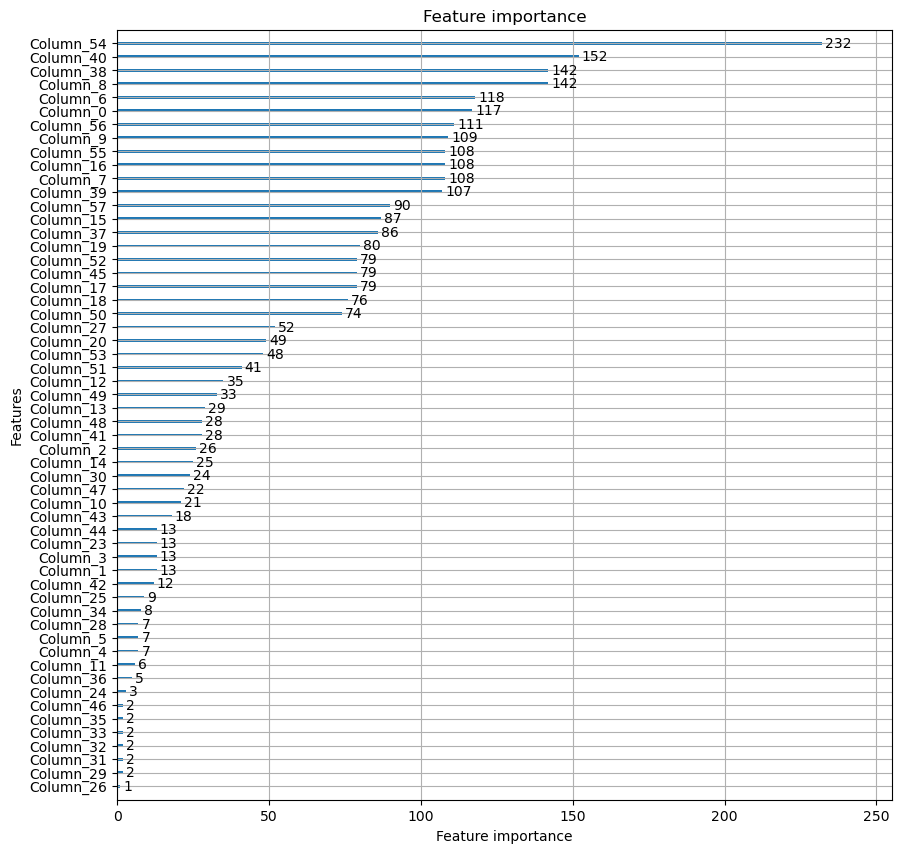

In [36]:
lgbm.plot_importance(lgb, index=X_train.columns_,figsize=(10, 10))

In [37]:
lgbm.plot_metric(lgb)

ValueError: eval results cannot be empty.

## 4. 予測結果の作成
最後にテストデータに対して予測を行い、提出用のcsvファイルを作成します。

In [ ]:
# テストデータに対する予測値の作成
pred = lgb.predict_proba(X_test, num_iteration=lgb.best_iteration)[:, 1]
# pred = lgb.predic_proba(X_test)[:, 1]

ValueError: Number of features of the model must match the input. Model n_features_ is 59 and input n_features is 58

In [ ]:
# 予測結果を提出用のフォーマットに格納
sample_sub['TARGET'] = pred
sample_sub

NameError: name 'pred' is not defined

In [ ]:
# 提出用のcsvファイルを作成
# formatを指定して現在時刻を取得（yyyyMMddhhmm）

sample_sub.to_csv(f'{output_path}/{time}.csv',index=False)

以上で、Home Credit Default Riskコンペのチュートリアルは終了です。今回は、50種類ある特徴量のうち5種類しか使用していないので、まだまだ改善の余地があります。この後は、このnotebookやこれまでの教材を参考にして、さらなるスコアの向上を目指してください！